# U.S. Bureau of Economic Analysis (BEA) API in Python

by Michael T. Moen

The U.S. Bureau of Economic Analysis (BEA) API provides programmatic access to economic data published by the BEA.

*This product uses the Bureau of Economic Analysis (BEA) Data API but is not endorsed or certified by BEA.*

Please see the following resources for more information on API usage:

- Documentation
    - <a href="https://apps.bea.gov/API/" target="_blank">BEA API Documentation</a>
    - <a href="https://apps.bea.gov/api/_pdf/bea_web_service_api_user_guide.pdf" target="_blank">BEA API User Guide</a>
    - <a href="https://www.bea.gov/itable/" target="_blank">BEA Interactive Data Application</a>
- Terms of Use
    - <a href="https://apps.bea.gov/API/_pdf/bea_api_tos.pdf" target="_blank">BEA API Terms of Use</a>

**_NOTE:_** The BEA API limits requests to a maximum of 100 requests/minute, 100 MB/minute, and 30 errors/minute.

*These recipe examples were tested on March 7, 2025.*

## Setup

### Import Libraries

The following external libraries need to be installed into your enviornment to run the code examples in this tutorial:

- <a href="https://github.com/ipython/ipykernel" target="_blank">ipykernel</a>
- <a href="https://github.com/psf/requests" target="_blank">requests</a>
- <a href="https://github.com/theskumar/python-dotenv" target="_blank">python-dotenv</a>
- <a href="https://github.com/matplotlib/matplotlib" target="_blank">matplotlib</a>

We import the libraries used in this tutorial below:

In [1]:
import os
import requests
import matplotlib.pyplot as plt
from dotenv import load_dotenv

### Import UserID

An UserID is required to access the BEA API. You can sign up for one <a href="https://apps.bea.gov/api/signup/" target="_blank">here</a>.

We keep our API key in a `.env` file and use the `dotenv` library to access it. If you would like to use this method, create a file named `.env` in the same directory as this notebook and add the following line to it:

```shell
BEA_API_USERID="add-userid-here"
```

In [2]:
load_dotenv()
try:
    USERID = os.environ["BEA_API_USERID"]
except KeyError:
    print("API key not found. Please set 'BEA_API_USERID' in your .env file.")

## 1. Finding Value Added by Industry in 2022

*Note: This section uses the GDP by Industry dataset, which can be explored <a href="https://apps.bea.gov/iTable/?reqid=150&step=2&isuri=1&categories=gdpxind&_gl=1*" target="_blank">here</a>.*

To get started, let's use the `GetDatasetList` method to get a list of all tables in the BEA database. In this example, we are interested in the `GDPbyIndustry` table.

Note that the `ResultFormat` is set to `JSON` in this URL, indicating that the API response will be in JSON. By default, the BEA API will return data in JSON, but it can also be set to XML if that is the format you would like to receive the response in. Later examples in this tutorial will not specify a `ResultFormat`. Additionally, the `UserID` parameter is set to the value specified in the Setup part of this tutorial.

In [3]:
BASE_URL = 'https://apps.bea.gov/api/data'
params = {
    'method': 'GetDatasetList',
    'ResultFormat': 'JSON',
    'UserID': USERID
}
data = requests.get(BASE_URL, params=params).json()

# Print tables with descriptions
for dataset in data['BEAAPI']['Results']['Dataset']:
    print(f'{dataset['DatasetName']:<25}: {dataset['DatasetDescription']}')

NIPA                     : Standard NIPA tables
NIUnderlyingDetail       : Standard NI underlying detail tables
MNE                      : Multinational Enterprises
FixedAssets              : Standard Fixed Assets tables
ITA                      : International Transactions Accounts
IIP                      : International Investment Position
InputOutput              : Input-Output Data
IntlServTrade            : International Services Trade
IntlServSTA              : International Services Supplied Through Affiliates
GDPbyIndustry            : GDP by Industry
Regional                 : Regional data sets
UnderlyingGDPbyIndustry  : Underlying GDP by Industry
APIDatasetMetaData       : Metadata about other API datasets


### Get Parameter Values

In order to query the data of the database, we must first determine the parameters necessary to make a request. To do this, we must use the `GetParameterList` method, which provides parameter names, descriptions, and information about the values accepted for the parameter, including whether it is required for a request.

In [4]:
params = {
    'method': 'GetParameterList',
    'datasetname': 'GDPbyIndustry',
    'UserID': USERID
}
data = requests.get(BASE_URL, params=params).json()

# Display response
data['BEAAPI']['Results']['Parameter']

[{'ParameterName': 'Frequency',
  'ParameterDataType': 'string',
  'ParameterDescription': 'A - Annual, Q-Quarterly',
  'ParameterIsRequiredFlag': '1',
  'ParameterDefaultValue': '',
  'MultipleAcceptedFlag': '1',
  'AllValue': 'ALL'},
 {'ParameterName': 'Industry',
  'ParameterDataType': 'string',
  'ParameterDescription': 'List of industries to retrieve (ALL for All)',
  'ParameterIsRequiredFlag': '1',
  'ParameterDefaultValue': '',
  'MultipleAcceptedFlag': '1',
  'AllValue': 'ALL'},
 {'ParameterName': 'TableID',
  'ParameterDataType': 'integer',
  'ParameterDescription': 'The unique GDP by Industry table identifier (ALL for All)',
  'ParameterIsRequiredFlag': '1',
  'ParameterDefaultValue': '',
  'MultipleAcceptedFlag': '1',
  'AllValue': 'ALL'},
 {'ParameterName': 'Year',
  'ParameterDataType': 'integer',
  'ParameterDescription': 'List of year(s) of data to retrieve (ALL for All)',
  'ParameterIsRequiredFlag': '1',
  'ParameterDefaultValue': '',
  'MultipleAcceptedFlag': '1',
  '

The result above indicates that there are 4 parameters required to query the `GDPbyIndustry` dataset: `Frequency`, `Industry`, `TableID`, and `Year`.

To find what values these parameters can take, we must use the `GetParameterValues` method. Using this method for the `Frequency` parameter returns a list of keys for each industry as well as the frequency at with which each is available (A for annually and Q for quarterly).

In [5]:
params = {
    'method': 'GetParameterValues',
    'datasetname': 'GDPbyIndustry',
    'ParameterName': 'Industry',
    'UserID': USERID
}
data = requests.get(BASE_URL, params=params).json()

# Print industry keys and descriptions
for parameter in data['BEAAPI']['Results']['ParamValue']:
    print(f'{parameter['Key']:<6}: {parameter['Desc']}')

11    : Agriculture, forestry, fishing, and hunting (A,Q)
111CA : Farms (A,Q)
113FF : Forestry, fishing, and related activities (A,Q)
21    : Mining (A,Q)
211   : Oil and gas extraction (A,Q)
212   : Mining, except oil and gas (A,Q)
213   : Support activities for mining (A,Q)
22    : Utilities (A,Q)
23    : Construction (A,Q)
311FT : Food and beverage and tobacco products (A,Q)
313TT : Textile mills and textile product mills (A,Q)
315AL : Apparel and leather and allied products (A,Q)
31G   : Manufacturing (A,Q)
31ND  : Nondurable goods (A,Q)
321   : Wood products (A,Q)
322   : Paper products (A,Q)
323   : Printing and related support activities (A,Q)
324   : Petroleum and coal products (A,Q)
325   : Chemical products (A,Q)
326   : Plastics and rubber products (A,Q)
327   : Nonmetallic mineral products (A,Q)
331   : Primary metals (A,Q)
332   : Fabricated metal products (A,Q)
333   : Machinery (A,Q)
334   : Computer and electronic products (A,Q)
335   : Electrical equipment, appliances,

Next, we use the same method to get the table IDs of the dataset:

In [6]:
params = {
    'method': 'GetParameterValues',
    'datasetname': 'GDPbyIndustry',
    'ParameterName': 'tableid',
    'UserID': USERID
}
data = requests.get(BASE_URL, params=params).json()

# Print TableIDs and descriptions
for parameter in data['BEAAPI']['Results']['ParamValue']:
    print(f'{parameter['Key']:<6}: {parameter['Desc']}')

1     : Value Added by Industry (A) (Q)
5     : Value added by Industry as a Percentage of Gross Domestic Product (A) (Q)
6     : Components of Value Added by Industry (A)
7     : Components of Value Added by Industry as a Percentage of Value Added (A)
8     : Chain-Type Quantity Indexes for Value Added by Industry (A) (Q)
9     : Percent Changes in Chain-Type Quantity Indexes for Value Added by Industry (A) (Q)
10    : Real Value Added by Industry (A) (Q)
11    : Chain-Type Price Indexes for Value Added by Industry (A) (Q)
12    : Percent Changes in Chain-Type Price Indexes for Value Added by Industry (A) (Q)
13    : Contributions to Percent Change in Real Gross Domestic Product by Industry (A) (Q)
14    : Contributions to Percent Change in the Chain-Type Price Index for Gross Domestic Product by Industry (A) (Q)
15    : Gross Output by Industry (A) (Q)
16    : Chain-Type Quantity Indexes for Gross Output by Industry (A) (Q)
17    : Percent Changes in Chain-Type Quantity Indexes for G

Finally, we look at the years available in the dataset:

In [7]:
params = {
    'method': 'GetParameterValues',
    'datasetname': 'GDPbyIndustry',
    'ParameterName': 'year',
    'UserID': USERID
}
data = requests.get(BASE_URL, params=params).json()

# Print years
for parameter in data['BEAAPI']['Results']['ParamValue']:
    print(parameter['Key'], end=", ")

1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 

### Get Data

Now that we have determined the parameters needed to retrieve the data we are looking for, we can use the `GetData` method to retrieve this data.

In this example, we use the `all` value for the industry parameter to obtain the data for all industries. Note that usage of this value should be limited in order to adhere to the API's rate limits.

In [8]:
params = {
    'method': 'GetData',
    'datasetname': 'GDPbyIndustry',
    'Industry': 'all',  # Data for all industries
    'Frequency': 'A',   # Annual data
    'tableid': 1,       # Value Added by Industry
    'year': 2022,       # Data for 2022
    'UserID': USERID
}
data = requests.get(BASE_URL, params=params).json()

# Display number of results
len(data['BEAAPI']['Results'][0]['Data'])

100

In [9]:
# Print results in a table
print(f'{'Industry':<75} Value Added (in million USD)')
for industry in data['BEAAPI']['Results'][0]['Data']:
    print(f'{industry['IndustrYDescription']:<75} {industry['DataValue']}')

Industry                                                                    Value Added (in million USD)
Agriculture, forestry, fishing, and hunting                                 290.0
Farms                                                                       241.9
Forestry, fishing, and related activities                                   48.1
Mining                                                                      460.6
Oil and gas extraction                                                      319.1
Mining, except oil and gas                                                  78.4
Support activities for mining                                               63.1
Utilities                                                                   443.6
Construction                                                                1114.3
Food and beverage and tobacco products                                      296.8
Textile mills and textile product mills                                     1

## 2. Finding Wages by Year through NIPA Tables

*Note: This section uses the National Income and Product Accounts (NIPA) dataset, which can be explored <a href="https://apps.bea.gov/iTable/?reqid=19&step=2&isuri=1&categories=survey" target="_blank">here</a>.*

In this section, we query the `NIPA` dataset. In order to find what parameters are necessary to query this dataset, we must first use the `GetParameterList`:

In [10]:
params = {
    'method': 'GetParameterList',
    'datasetname': 'NIPA',
    'UserID': USERID
}
data = requests.get(BASE_URL, params=params).json()

# Display response
data['BEAAPI']['Results']['Parameter']

[{'ParameterName': 'Frequency',
  'ParameterDataType': 'string',
  'ParameterDescription': 'A - Annual, Q-Quarterly, M-Monthly',
  'ParameterIsRequiredFlag': '1',
  'ParameterDefaultValue': '',
  'MultipleAcceptedFlag': '1',
  'AllValue': ''},
 {'ParameterName': 'ShowMillions',
  'ParameterDataType': 'string',
  'ParameterDescription': 'A flag indicating that million-dollar data should be returned.',
  'ParameterIsRequiredFlag': '0',
  'ParameterDefaultValue': 'N',
  'MultipleAcceptedFlag': '0',
  'AllValue': ''},
 {'ParameterName': 'TableID',
  'ParameterDataType': 'integer',
  'ParameterDescription': 'The standard NIPA table identifier',
  'ParameterIsRequiredFlag': '0',
  'MultipleAcceptedFlag': '0',
  'AllValue': ''},
 {'ParameterName': 'TableName',
  'ParameterDataType': 'string',
  'ParameterDescription': 'The new NIPA table identifier',
  'ParameterIsRequiredFlag': '0',
  'MultipleAcceptedFlag': '0',
  'AllValue': ''},
 {'ParameterName': 'Year',
  'ParameterDataType': 'integer',

Now, we use the `GetParameterValues` function to find what parameter values we can use in our API request. The example below finds the values for the `year` and `TableID` parameters:

In [11]:
method = 'GetParameterValues'
dataset = 'NIPA'

# Find years available for each table
params = {
    'method': method,
    'datasetname': dataset,
    'ParameterName': 'year',
    'UserID': USERID
}
year_data = requests.get(BASE_URL, params=params).json()

a_years = {}       # Years that have annual data available
q_years = {}    # Years that have quarterly data available
for table in year_data['BEAAPI']['Results']['ParamValue']:
    a_years[table['TableName']] = (table['FirstAnnualYear'], table['LastAnnualYear'])
    q_years[table['TableName']] = (table['FirstQuarterlyYear'], table['LastQuarterlyYear'])

# Find table IDs
params = {
    'method': method,
    'datasetname': dataset,
    'ParameterName': 'TableID',
    'UserID': USERID
}
table_id_data = requests.get(BASE_URL, params=params).json()

# Display table names, descriptions, and years available
print(f'{'Table':<8}| {'Annually':<9} | {'Quarterly':<9} | Description')
for id in table_id_data['BEAAPI']['Results']['ParamValue']:
    name = id['TableName']
    print(f'{name:<8}| {a_years[name][0]:>4}-{a_years[name][1]:>4} | '
          f'{q_years[name][0]:>4}-{q_years[name][1]:>4} | {id['Description']}')

Table   | Annually  | Quarterly | Description
T10101  | 1930-2024 | 1947-2024 | Table 1.1.1. Percent Change From Preceding Period in Real Gross Domestic Product (A) (Q)
T10102  | 1930-2024 | 1947-2024 | Table 1.1.2. Contributions to Percent Change in Real Gross Domestic Product (A) (Q)
T10103  | 1929-2024 | 1947-2024 | Table 1.1.3. Real Gross Domestic Product, Quantity Indexes (A) (Q)
T10104  | 1929-2024 | 1947-2024 | Table 1.1.4. Price Indexes for Gross Domestic Product (A) (Q)
T10105  | 1929-2024 | 1947-2024 | Table 1.1.5. Gross Domestic Product (A) (Q)
T10106  | 1929-2024 | 1947-2024 | Table 1.1.6. Real Gross Domestic Product, Chained Dollars (A) (Q)
T10107  | 1930-2024 | 1947-2024 | Table 1.1.7. Percent Change From Preceding Period in Prices for Gross Domestic Product (A) (Q)
T10108  | 1930-2024 | 1947-2024 | Table 1.1.8. Contributions to Percent Change in the Gross Domestic Product Price Index (A) (Q)
T10109  | 1929-2024 | 1947-2024 | Table 1.1.9. Implicit Price Deflators for Gros

From the table printed above, we see that table `T60300D` has annual data from 1998 to 2023 for "Wages and Salaries by Industry." Below, we use the `GetData` method to retrieve the annual data from this table for every available year:

In [12]:
params = {
    'method': 'GetData',
    'datasetname': 'NIPA',
    'Frequency': 'A',       # Annual data
    'TableName': 'T60300D', # Wages and Salaries by Industry
    'year': 'X',            # Data for 1998-2022
    'UserID': USERID
}
data = requests.get(BASE_URL, params=params).json()

# Display size of data [number of industries (99) x number of years (25)]
len(data['BEAAPI']['Results']['Data'])

2574

In [13]:
data['BEAAPI']['Results']['Data'][:3]

[{'TableName': 'T60300D',
  'SeriesCode': 'A034RC',
  'LineNumber': '1',
  'LineDescription': 'Wages and salaries',
  'TimePeriod': '1998',
  'METRIC_NAME': 'Current Dollars',
  'CL_UNIT': 'Level',
  'UNIT_MULT': '6',
  'DataValue': '4,181,616',
  'NoteRef': 'T60300D'},
 {'TableName': 'T60300D',
  'SeriesCode': 'A034RC',
  'LineNumber': '1',
  'LineDescription': 'Wages and salaries',
  'TimePeriod': '1999',
  'METRIC_NAME': 'Current Dollars',
  'CL_UNIT': 'Level',
  'UNIT_MULT': '6',
  'DataValue': '4,457,926',
  'NoteRef': 'T60300D'},
 {'TableName': 'T60300D',
  'SeriesCode': 'A034RC',
  'LineNumber': '1',
  'LineDescription': 'Wages and salaries',
  'TimePeriod': '2000',
  'METRIC_NAME': 'Current Dollars',
  'CL_UNIT': 'Level',
  'UNIT_MULT': '6',
  'DataValue': '4,824,946',
  'NoteRef': 'T60300D'}]

In [14]:
industries = [
    'Agriculture, forestry, fishing, and hunting', 'Mining', 'Utilities', 'Construction',
    'Manufacturing', 'Wholesale trade', 'Retail trade', 'Transportation and warehousing',
    'Information', 'Finance and insurance', 'Real estate and rental and leasing',
    'Professional, scientific, and technical services',
    'Management of companies and enterprises', 'Administrative and waste management services',
    'Educational services', 'Health care and social assistance',
    'Arts, entertainment, and recreation', 'Accommodation and food services',
    'Other services, except government', 'Government'
]

data_by_industry = []
for industry in industries:
    years_values = []
    for item in data['BEAAPI']['Results']['Data']:
        if item['LineDescription'] == industry:
            year = int(item['TimePeriod'])
            value = int(item['DataValue'].replace(',', ''))
            value /= 1000   # Convert value to billions
            years_values.append((year, value))
    data_by_industry.append((industry, years_values))

# Display length of results (number of years)
len(data_by_industry)

20

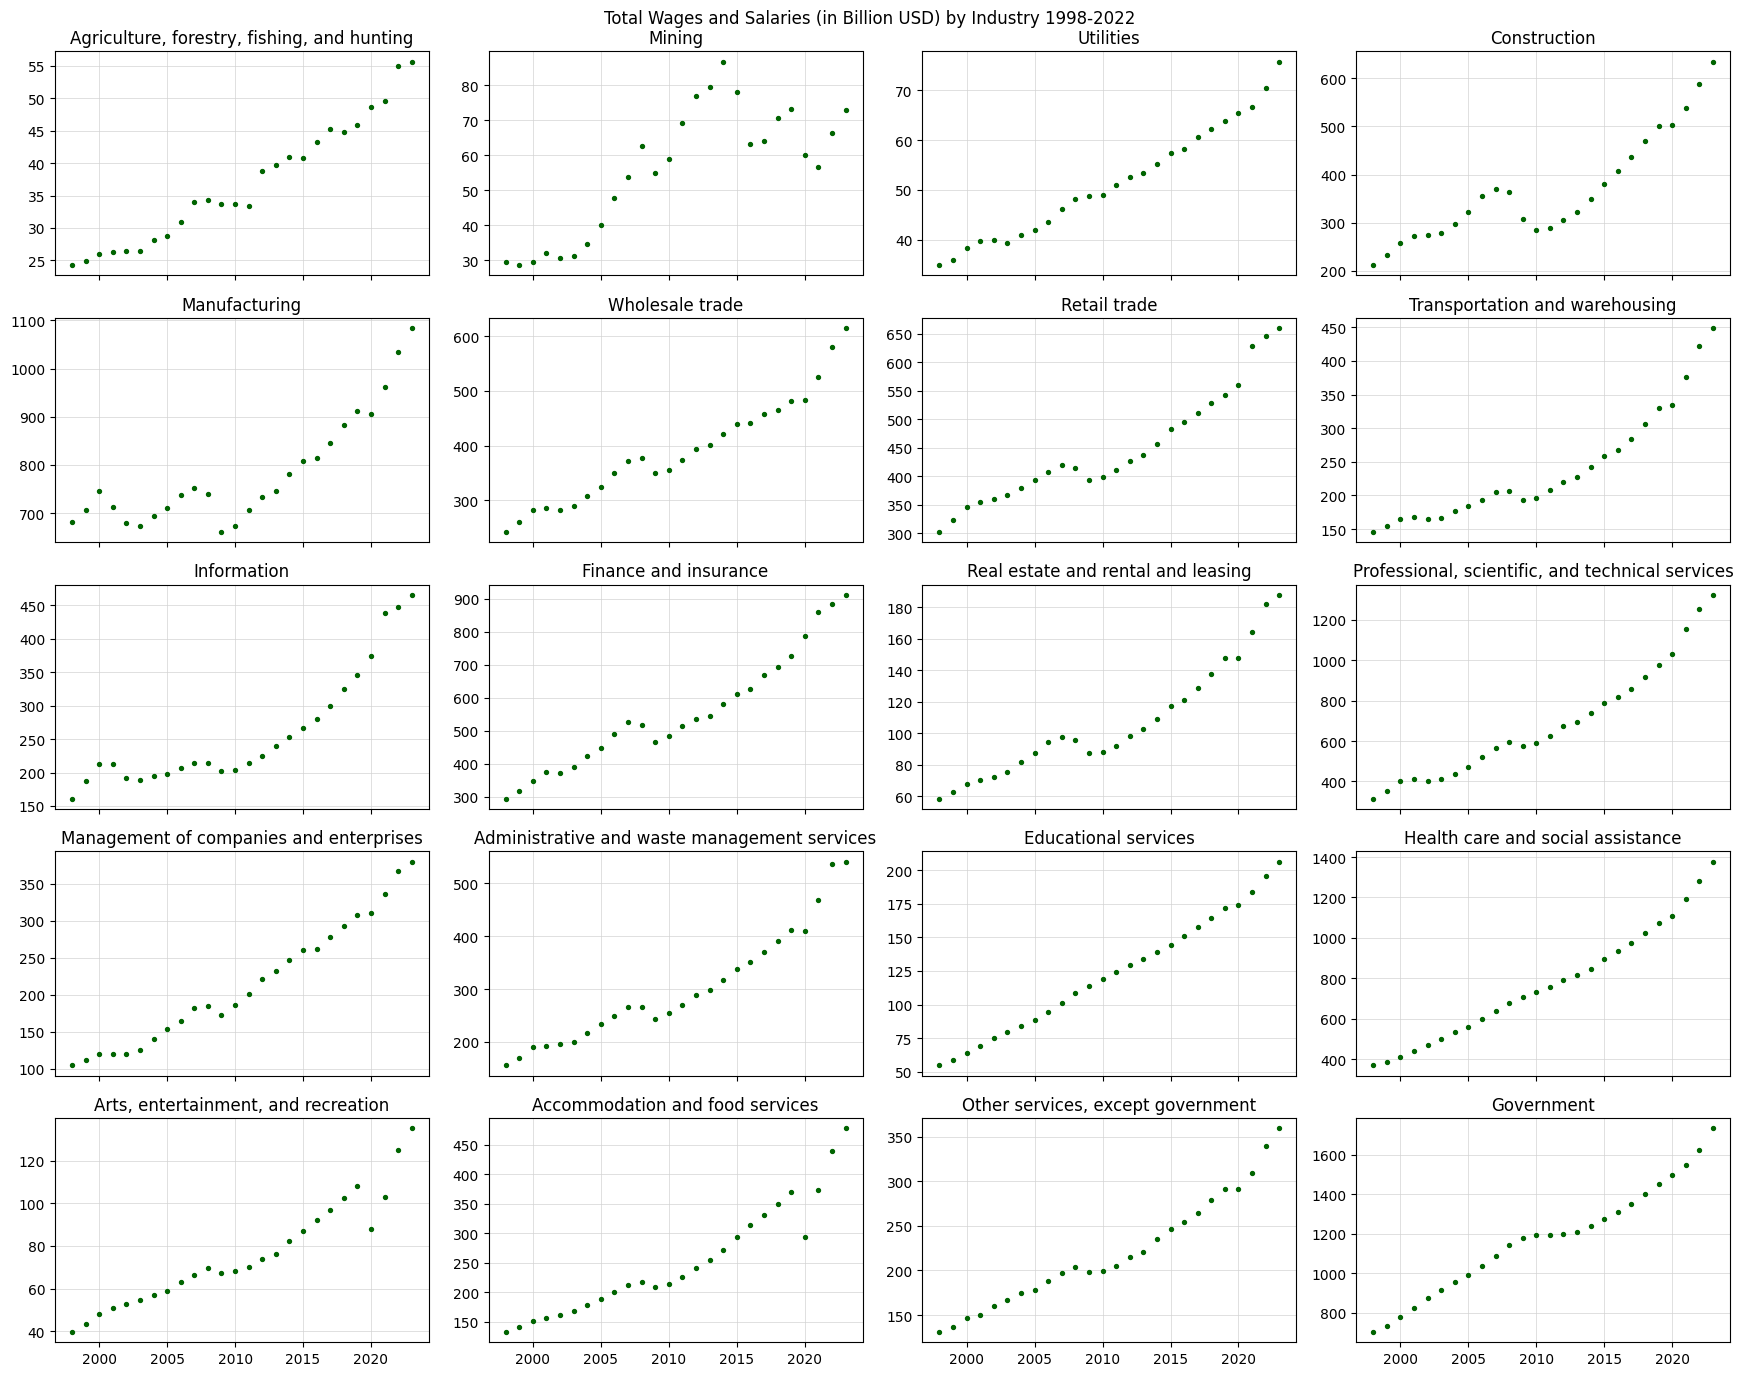

In [15]:
fig, axs = plt.subplots(5, 4, figsize=(17.5, 14), sharex=True)
fig.suptitle('Total Wages and Salaries (in Billion USD) by Industry 1998-2022')

for i in range(20):
    x = i // 4  # x-coordinate of graph (row number)
    y = i % 4   # y-coordinate of graph (column number)

    industry_name = data_by_industry[i][0]
    years, values = zip(*data_by_industry[i][1])
    
    axs[x, y].scatter(years, values, s=8, color='darkgreen')
    axs[x, y].set_title(industry_name)
    axs[x, y].grid(linewidth=0.5, color='lightgray')
    axs[x, y].set_axisbelow(True)

plt.tight_layout()
plt.show()

Note that the graphs below are not scaled together. Please check the y-axis labels to see the individual scales for each graph.